In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("paper")
#Load Data
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5")

norm = image.norm
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.1, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.1, "upper": upper},
                    
}

# Define Model
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

# Train Model
mm.fit(n_components=60, show_results = False)

File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))
Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_fu

In [2]:
data = mm.datamatrix.reshape(12484,3,64,64)


In [5]:
data.shape
data[:,0,:]

(12484, 64, 64)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import trange
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, layer_size_1):
        super(Net, self).__init__()
        # Define the layers of your neural network
        self.fc1 = nn.Linear(layer_size_1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 60)  # 60 output nodes for PCA scores

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Step 3: Split the dataset into training and testing sets

# Step 4: Train the neural network
img_size = 64 * 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net(layer_size_1=img_size).to(device)
criterion = nn.MSELoss().to(device)  # Use mean squared error as the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Choose an optimizer

num_epochs = 3000

data = mm.datamatrix.reshape(12484, 3, 64, 64)
data = data[:, 0, :]  # Use only the first map to learn the scores
targets = mm.scores

# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, random_state=42)

# Assuming you have your training data and targets as tensors
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

# Convert training data and targets into a TensorDataset
train_dataset = TensorDataset(train_data, train_targets)

# Define the batch size for training
batch_size = 64

# Create the train_loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_loss = []
# Training time: 45 min
for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:  # Iterate over the training set
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch%80 ==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

# Step 5: Evaluate the trained model
# Compute predicted PCA components for the testing set
# Compare predicted components with ground truth and calculate evaluation metrics
plt.plot(np.arange(len(train_loss)), train_loss)

  0%|          | 1/1000 [00:00<07:12,  2.31it/s]

Epoch 1/1000, Loss: 4.223371684930886


  1%|          | 11/1000 [00:04<06:44,  2.45it/s]

Epoch 11/1000, Loss: 2.995316865337882


  2%|▏         | 21/1000 [00:08<06:37,  2.46it/s]

Epoch 21/1000, Loss: 2.8073453371691857


  3%|▎         | 31/1000 [00:12<06:20,  2.55it/s]

Epoch 31/1000, Loss: 2.7113615494624823


  4%|▍         | 41/1000 [00:16<06:01,  2.65it/s]

Epoch 41/1000, Loss: 2.6150225287030455


  5%|▌         | 51/1000 [00:20<06:04,  2.60it/s]

Epoch 51/1000, Loss: 2.535250313722404


  6%|▌         | 61/1000 [00:24<06:04,  2.57it/s]

Epoch 61/1000, Loss: 2.4542846892290053


  7%|▋         | 71/1000 [00:27<06:03,  2.56it/s]

Epoch 71/1000, Loss: 2.383003597806214


  8%|▊         | 81/1000 [00:31<05:58,  2.56it/s]

Epoch 81/1000, Loss: 2.3544559623025787


  9%|▉         | 91/1000 [00:36<06:35,  2.30it/s]

Epoch 91/1000, Loss: 2.2654682413028304


 10%|█         | 101/1000 [00:40<06:27,  2.32it/s]

Epoch 101/1000, Loss: 2.2098359401059


 11%|█         | 111/1000 [00:44<06:31,  2.27it/s]

Epoch 111/1000, Loss: 2.268685595245118


 12%|█▏        | 121/1000 [00:48<05:49,  2.51it/s]

Epoch 121/1000, Loss: 2.1231234825340803


 13%|█▎        | 131/1000 [00:52<05:39,  2.56it/s]

Epoch 131/1000, Loss: 2.062046326649417


 14%|█▍        | 141/1000 [00:56<05:35,  2.56it/s]

Epoch 141/1000, Loss: 2.060185314743382


 15%|█▌        | 151/1000 [01:00<05:30,  2.57it/s]

Epoch 151/1000, Loss: 2.0070442788919824


 16%|█▌        | 161/1000 [01:04<05:33,  2.52it/s]

Epoch 161/1000, Loss: 1.9502980397765044


 17%|█▋        | 171/1000 [01:08<05:24,  2.55it/s]

Epoch 171/1000, Loss: 2.046025926140463


 18%|█▊        | 181/1000 [01:12<05:19,  2.57it/s]

Epoch 181/1000, Loss: 1.9096308065827485


 19%|█▉        | 191/1000 [01:16<05:15,  2.56it/s]

Epoch 191/1000, Loss: 1.9454868614293968


 20%|██        | 201/1000 [01:20<05:09,  2.58it/s]

Epoch 201/1000, Loss: 1.8628064272510019


 21%|██        | 211/1000 [01:23<05:03,  2.60it/s]

Epoch 211/1000, Loss: 1.8246726944188403


 22%|██▏       | 221/1000 [01:27<04:58,  2.61it/s]

Epoch 221/1000, Loss: 1.7809877820834992


 23%|██▎       | 231/1000 [01:31<04:56,  2.60it/s]

Epoch 231/1000, Loss: 1.7902359522072373


 24%|██▍       | 241/1000 [01:35<04:55,  2.57it/s]

Epoch 241/1000, Loss: 1.754014586946767


 25%|██▌       | 251/1000 [01:39<04:46,  2.61it/s]

Epoch 251/1000, Loss: 1.7562170787981362


 26%|██▌       | 261/1000 [01:43<04:43,  2.61it/s]

Epoch 261/1000, Loss: 1.7482415278246448


 27%|██▋       | 271/1000 [01:47<04:38,  2.62it/s]

Epoch 271/1000, Loss: 1.7329221098286332


 28%|██▊       | 281/1000 [01:50<04:34,  2.62it/s]

Epoch 281/1000, Loss: 1.688486821332555


 29%|██▉       | 291/1000 [01:54<04:32,  2.61it/s]

Epoch 291/1000, Loss: 1.7042394618319858


 30%|███       | 301/1000 [01:58<04:28,  2.60it/s]

Epoch 301/1000, Loss: 1.6900829091952865


 31%|███       | 311/1000 [02:02<04:23,  2.61it/s]

Epoch 311/1000, Loss: 1.6763002773758713


 32%|███▏      | 321/1000 [02:06<04:19,  2.62it/s]

Epoch 321/1000, Loss: 1.6719681206782153


 33%|███▎      | 331/1000 [02:10<04:16,  2.61it/s]

Epoch 331/1000, Loss: 1.6589758365776888


 34%|███▍      | 341/1000 [02:13<04:12,  2.61it/s]

Epoch 341/1000, Loss: 1.6253514267077112


 35%|███▌      | 351/1000 [02:17<04:08,  2.62it/s]

Epoch 351/1000, Loss: 1.6321776353629531


 36%|███▌      | 361/1000 [02:21<04:04,  2.61it/s]

Epoch 361/1000, Loss: 1.6527442415808415


 37%|███▋      | 371/1000 [02:25<04:01,  2.61it/s]

Epoch 371/1000, Loss: 1.5978516028944854


 38%|███▊      | 381/1000 [02:29<03:56,  2.62it/s]

Epoch 381/1000, Loss: 1.5775807032919233


 39%|███▉      | 391/1000 [02:33<03:52,  2.61it/s]

Epoch 391/1000, Loss: 1.5945599846019867


 40%|████      | 401/1000 [02:36<03:51,  2.59it/s]

Epoch 401/1000, Loss: 1.5807204815992124


 41%|████      | 411/1000 [02:40<03:47,  2.59it/s]

Epoch 411/1000, Loss: 1.574943991223718


 42%|████▏     | 421/1000 [02:44<03:44,  2.58it/s]

Epoch 421/1000, Loss: 1.5990416623984174


 43%|████▎     | 431/1000 [02:48<03:38,  2.60it/s]

Epoch 431/1000, Loss: 1.5770902238833677


 44%|████▍     | 441/1000 [02:52<03:35,  2.59it/s]

Epoch 441/1000, Loss: 1.5401636794873863


 45%|████▌     | 451/1000 [02:56<03:31,  2.59it/s]

Epoch 451/1000, Loss: 1.5626748883800141


 46%|████▌     | 461/1000 [03:00<03:27,  2.60it/s]

Epoch 461/1000, Loss: 1.5384994380792993


 47%|████▋     | 471/1000 [03:03<03:23,  2.60it/s]

Epoch 471/1000, Loss: 1.5183872333757438


 48%|████▊     | 481/1000 [03:07<03:19,  2.60it/s]

Epoch 481/1000, Loss: 1.5557036172052858


 49%|████▉     | 491/1000 [03:11<03:16,  2.60it/s]

Epoch 491/1000, Loss: 1.5219917790904927


 50%|█████     | 501/1000 [03:15<03:13,  2.58it/s]

Epoch 501/1000, Loss: 1.4953343989742789


 51%|█████     | 511/1000 [03:19<03:08,  2.59it/s]

Epoch 511/1000, Loss: 1.495250181787333


 52%|█████▏    | 521/1000 [03:23<03:04,  2.60it/s]

Epoch 521/1000, Loss: 1.4840208808327937


 53%|█████▎    | 531/1000 [03:27<03:00,  2.60it/s]

Epoch 531/1000, Loss: 1.473689234180815


 54%|█████▍    | 541/1000 [03:30<02:58,  2.57it/s]

Epoch 541/1000, Loss: 1.5097716765798581


 55%|█████▌    | 551/1000 [03:34<02:53,  2.59it/s]

Epoch 551/1000, Loss: 1.4951046424306882


 56%|█████▌    | 561/1000 [03:38<02:49,  2.59it/s]

Epoch 561/1000, Loss: 1.4860405846006552


 57%|█████▋    | 571/1000 [03:42<02:45,  2.59it/s]

Epoch 571/1000, Loss: 1.471895895945798


 58%|█████▊    | 581/1000 [03:46<02:41,  2.59it/s]

Epoch 581/1000, Loss: 1.4648972153663635


 59%|█████▉    | 591/1000 [03:50<02:38,  2.58it/s]

Epoch 591/1000, Loss: 1.496961072751671


 60%|██████    | 601/1000 [03:54<02:32,  2.61it/s]

Epoch 601/1000, Loss: 1.4651783401039755


 61%|██████    | 611/1000 [03:58<02:29,  2.61it/s]

Epoch 611/1000, Loss: 1.4686436053294285


 62%|██████▏   | 621/1000 [04:01<02:25,  2.60it/s]

Epoch 621/1000, Loss: 1.431714686618489


 63%|██████▎   | 631/1000 [04:05<02:22,  2.59it/s]

Epoch 631/1000, Loss: 1.458140544071319


 64%|██████▍   | 641/1000 [04:09<02:17,  2.61it/s]

Epoch 641/1000, Loss: 1.4156786609607137


 65%|██████▌   | 651/1000 [04:13<02:13,  2.61it/s]

Epoch 651/1000, Loss: 1.4602739818536552


 66%|██████▌   | 661/1000 [04:17<02:10,  2.61it/s]

Epoch 661/1000, Loss: 1.4420604121153522


 67%|██████▋   | 671/1000 [04:21<02:06,  2.60it/s]

Epoch 671/1000, Loss: 1.4264051982551624


 68%|██████▊   | 681/1000 [04:24<02:01,  2.62it/s]

Epoch 681/1000, Loss: 1.420815958338938


 69%|██████▉   | 691/1000 [04:28<01:58,  2.61it/s]

Epoch 691/1000, Loss: 1.4487280192648528


 70%|███████   | 701/1000 [04:32<01:54,  2.61it/s]

Epoch 701/1000, Loss: 1.42505180228288


 71%|███████   | 711/1000 [04:36<01:51,  2.59it/s]

Epoch 711/1000, Loss: 1.406038346943582


 72%|███████▏  | 721/1000 [04:40<01:49,  2.54it/s]

Epoch 721/1000, Loss: 1.4260119404762415


 73%|███████▎  | 731/1000 [04:44<01:45,  2.55it/s]

Epoch 731/1000, Loss: 1.432570196261072


 74%|███████▍  | 741/1000 [04:48<01:41,  2.55it/s]

Epoch 741/1000, Loss: 1.4102344497753556


 75%|███████▌  | 751/1000 [04:52<01:37,  2.55it/s]

Epoch 751/1000, Loss: 1.415796599190706


 76%|███████▌  | 761/1000 [04:56<01:33,  2.55it/s]

Epoch 761/1000, Loss: 1.4091409429623063


 77%|███████▋  | 771/1000 [05:00<01:32,  2.48it/s]

Epoch 771/1000, Loss: 1.3881036210211979


 78%|███████▊  | 781/1000 [05:03<01:24,  2.59it/s]

Epoch 781/1000, Loss: 1.4304602115776888


 79%|███████▉  | 791/1000 [05:07<01:20,  2.59it/s]

Epoch 791/1000, Loss: 1.394418725542202


 80%|████████  | 801/1000 [05:11<01:17,  2.58it/s]

Epoch 801/1000, Loss: 1.4115407576986179


 81%|████████  | 811/1000 [05:15<01:13,  2.56it/s]

Epoch 811/1000, Loss: 1.4297311533788206


 82%|████████▏ | 821/1000 [05:19<01:09,  2.57it/s]

Epoch 821/1000, Loss: 1.3863781155294674


 83%|████████▎ | 831/1000 [05:23<01:05,  2.56it/s]

Epoch 831/1000, Loss: 1.38360565255402


 84%|████████▍ | 841/1000 [05:27<01:02,  2.55it/s]

Epoch 841/1000, Loss: 1.3838340199677048


 85%|████████▌ | 851/1000 [05:31<00:58,  2.56it/s]

Epoch 851/1000, Loss: 1.3553490653918807


 86%|████████▌ | 861/1000 [05:35<00:54,  2.56it/s]

Epoch 861/1000, Loss: 1.3504635968785377


 87%|████████▋ | 871/1000 [05:39<00:50,  2.56it/s]

Epoch 871/1000, Loss: 1.3906804254859875


 88%|████████▊ | 881/1000 [05:42<00:46,  2.55it/s]

Epoch 881/1000, Loss: 1.3526390069609235


 89%|████████▉ | 891/1000 [05:46<00:42,  2.57it/s]

Epoch 891/1000, Loss: 1.44551441244259


 90%|█████████ | 901/1000 [05:50<00:38,  2.58it/s]

Epoch 901/1000, Loss: 1.3463610133547692


 91%|█████████ | 911/1000 [05:54<00:34,  2.56it/s]

Epoch 911/1000, Loss: 1.357959883987524


 92%|█████████▏| 921/1000 [05:58<00:30,  2.58it/s]

Epoch 921/1000, Loss: 1.3495688696575772


 93%|█████████▎| 931/1000 [06:02<00:26,  2.57it/s]

Epoch 931/1000, Loss: 1.3884412695647805


 94%|█████████▍| 941/1000 [06:06<00:22,  2.57it/s]

Epoch 941/1000, Loss: 1.4215384953340906


 95%|█████████▌| 951/1000 [06:10<00:19,  2.57it/s]

Epoch 951/1000, Loss: 1.347270988355017


 96%|█████████▌| 961/1000 [06:14<00:15,  2.55it/s]

Epoch 961/1000, Loss: 1.3825356998261373


 97%|█████████▋| 971/1000 [06:17<00:11,  2.54it/s]

Epoch 971/1000, Loss: 1.3574619862684019


 98%|█████████▊| 981/1000 [06:21<00:07,  2.55it/s]

Epoch 981/1000, Loss: 1.3381263496010167


 99%|█████████▉| 991/1000 [06:25<00:03,  2.54it/s]

Epoch 991/1000, Loss: 1.3534311625608213


100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]


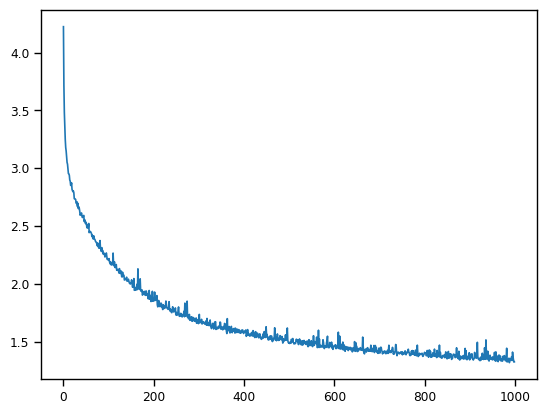

In [14]:
# Put the model in evaluation mode
model.eval()

# Create tensors for the test data
test_data = torch.Tensor(test_data).to(device)
test_targets = torch.Tensor(test_targets).to(device)

# Create a test dataset
test_dataset = TensorDataset(test_data, test_targets)

# Create a test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Lists to store predicted PCA components
predicted_scores = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, targets in test_loader:
        # Move inputs to the GPU device
        inputs = inputs.to(device)

        # Forward pass
        outputs = model(inputs)

        # Move outputs back to the CPU
        outputs = outputs.cpu().numpy()

        predicted_scores.append(outputs)

# Concatenate predicted PCA components
predscores = np.concatenate(predicted_scores)


In [16]:
def evaluate_prediction(predicted_score, target_score, plot = True):
    reconstructed_images_pred = mm.reconstruct(predicted_score)
    reconstructed_images_target = mm.reconstruct(target_score)
    # Make residual plots for all 3 maps
    # Calculate residuals for each map
    residuals = np.abs(reconstructed_images_pred - reconstructed_images_target) / reconstructed_images_target * 100

    reconstruction_error = np.median(residuals)
    if not plot: return reconstruction_error
    # Plot the original images, reconstructed images, and residuals
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    # Iterate over the maps
    for i in range(3):
        # Plot original image
        axes[i, 0].imshow(reconstructed_images_target[i])
        axes[i, 0].set_title(f"Ground Truth Map {i+1}")
        # Plot reconstructed image from predicted scores
        axes[i, 1].imshow(reconstructed_images_pred[i])
        axes[i, 1].set_title(f"Reconstructed (Predicted) Map {i+1}")

        axes[i,2].imshow(residuals[i], cmap = "coolwarm",vmin=-100, vmax=100)
        axes[i, 2].set_title(f"Residual {i+1}")

        
        

        # Set axis labels
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()
    return reconstruction_error

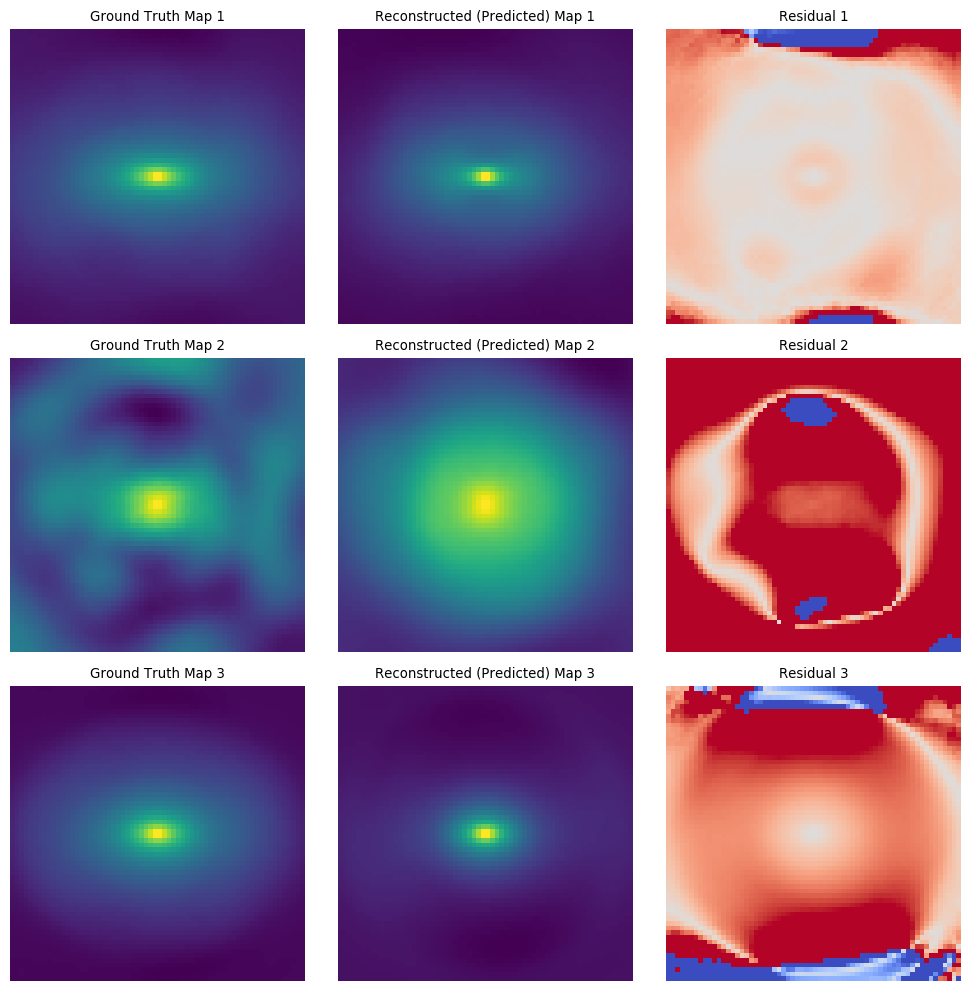

54.91424350389804

In [32]:
index = 10
evaluate_prediction(predscores[index], test_targets[index].cpu())

In [34]:
# Continoue training:
model.train()
num_epochs = 2000
for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:  # Iterate over the training set
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch%80 ==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

  0%|          | 1/2000 [00:00<15:39,  2.13it/s]

Epoch 1/2000, Loss: 1.335872169512852


  4%|▍         | 81/2000 [00:33<13:01,  2.46it/s]

Epoch 81/2000, Loss: 1.32957317988584


  8%|▊         | 161/2000 [01:04<12:42,  2.41it/s]

Epoch 161/2000, Loss: 1.3152617087030107


 12%|█▏        | 241/2000 [01:36<11:24,  2.57it/s]

Epoch 241/2000, Loss: 1.3364331813374901


 16%|█▌        | 321/2000 [02:07<11:06,  2.52it/s]

Epoch 321/2000, Loss: 1.2873689930909757


 20%|██        | 401/2000 [02:39<10:46,  2.47it/s]

Epoch 401/2000, Loss: 1.2752923540248993


 24%|██▍       | 481/2000 [03:10<09:50,  2.57it/s]

Epoch 481/2000, Loss: 1.2890907590556298


 28%|██▊       | 561/2000 [03:41<09:18,  2.58it/s]

Epoch 561/2000, Loss: 1.264985198427917


 32%|███▏      | 641/2000 [04:12<08:48,  2.57it/s]

Epoch 641/2000, Loss: 1.2530274345616625


 36%|███▌      | 721/2000 [04:43<08:11,  2.60it/s]

Epoch 721/2000, Loss: 1.2598355203677134


 40%|████      | 801/2000 [05:15<07:58,  2.51it/s]

Epoch 801/2000, Loss: 1.2445101965764525


 44%|████▍     | 881/2000 [05:46<07:21,  2.54it/s]

Epoch 881/2000, Loss: 1.2407687260846423


 48%|████▊     | 961/2000 [06:18<06:47,  2.55it/s]

Epoch 961/2000, Loss: 1.2218720426984653


 52%|█████▏    | 1041/2000 [06:50<06:06,  2.61it/s]

Epoch 1041/2000, Loss: 1.210810132087416


 56%|█████▌    | 1121/2000 [07:20<05:37,  2.61it/s]

Epoch 1121/2000, Loss: 1.2234847553216728


 60%|██████    | 1201/2000 [07:52<05:12,  2.56it/s]

Epoch 1201/2000, Loss: 1.2475083314689102


 64%|██████▍   | 1281/2000 [08:23<04:58,  2.41it/s]

Epoch 1281/2000, Loss: 1.1973266814165056


 68%|██████▊   | 1361/2000 [08:55<04:11,  2.54it/s]

Epoch 1361/2000, Loss: 1.2326105066165802


 72%|███████▏  | 1441/2000 [09:26<03:35,  2.59it/s]

Epoch 1441/2000, Loss: 1.1780992006040683


 76%|███████▌  | 1521/2000 [09:58<03:08,  2.54it/s]

Epoch 1521/2000, Loss: 1.2170504012684913


 80%|████████  | 1601/2000 [10:30<02:37,  2.54it/s]

Epoch 1601/2000, Loss: 1.2075488795140745


 84%|████████▍ | 1681/2000 [11:01<02:05,  2.55it/s]

Epoch 1681/2000, Loss: 1.1755800156077003


 88%|████████▊ | 1761/2000 [11:33<01:33,  2.55it/s]

Epoch 1761/2000, Loss: 1.3247766320113163


 92%|█████████▏| 1841/2000 [12:04<01:01,  2.59it/s]

Epoch 1841/2000, Loss: 1.1623922882566027


 96%|█████████▌| 1921/2000 [12:35<00:30,  2.59it/s]

Epoch 1921/2000, Loss: 1.1689874055279288


100%|██████████| 2000/2000 [13:05<00:00,  2.55it/s]


In [35]:
# Continoue training:
model.train()
num_epochs = 2000
for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:  # Iterate over the training set
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch%80 ==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

  0%|          | 1/2000 [00:00<13:04,  2.55it/s]

Epoch 1/2000, Loss: 1.1546351245254467


  4%|▍         | 81/2000 [00:31<12:30,  2.56it/s]

Epoch 81/2000, Loss: 1.1441874542054098


  8%|▊         | 161/2000 [01:02<11:49,  2.59it/s]

Epoch 161/2000, Loss: 1.1409850215456288


 12%|█▏        | 241/2000 [01:33<11:18,  2.59it/s]

Epoch 241/2000, Loss: 1.1379375286922333


 16%|█▌        | 321/2000 [02:04<10:48,  2.59it/s]

Epoch 321/2000, Loss: 1.1316579322146763


 20%|██        | 401/2000 [02:35<10:32,  2.53it/s]

Epoch 401/2000, Loss: 1.1374777563058647


 24%|██▍       | 481/2000 [03:06<09:41,  2.61it/s]

Epoch 481/2000, Loss: 1.2919562584275652


 28%|██▊       | 561/2000 [03:37<09:13,  2.60it/s]

Epoch 561/2000, Loss: 1.1165865078853194


 32%|███▏      | 641/2000 [04:07<08:42,  2.60it/s]

Epoch 641/2000, Loss: 1.1223557507915862


 36%|███▌      | 721/2000 [04:38<08:11,  2.60it/s]

Epoch 721/2000, Loss: 1.1247961790698349


 40%|████      | 801/2000 [05:10<07:55,  2.52it/s]

Epoch 801/2000, Loss: 1.1317419219928182


 44%|████▍     | 881/2000 [05:41<07:18,  2.55it/s]

Epoch 881/2000, Loss: 1.1240494152542893


 48%|████▊     | 961/2000 [06:13<06:49,  2.54it/s]

Epoch 961/2000, Loss: 1.1282496000551114


 52%|█████▏    | 1041/2000 [06:45<06:22,  2.51it/s]

Epoch 1041/2000, Loss: 1.1075723679961673


 56%|█████▌    | 1121/2000 [07:17<05:47,  2.53it/s]

Epoch 1121/2000, Loss: 1.1211456728589004


 60%|██████    | 1201/2000 [07:49<05:13,  2.55it/s]

Epoch 1201/2000, Loss: 1.1502767679797616


 64%|██████▍   | 1281/2000 [08:20<04:46,  2.51it/s]

Epoch 1281/2000, Loss: 1.1002784675093973


 68%|██████▊   | 1361/2000 [08:52<04:12,  2.53it/s]

Epoch 1361/2000, Loss: 1.0963496501278724


 72%|███████▏  | 1441/2000 [09:23<03:35,  2.59it/s]

Epoch 1441/2000, Loss: 1.1106566562774076


 76%|███████▌  | 1521/2000 [09:55<03:08,  2.55it/s]

Epoch 1521/2000, Loss: 1.090922425886628


 80%|████████  | 1601/2000 [10:26<02:36,  2.55it/s]

Epoch 1601/2000, Loss: 1.0768386744389868


 84%|████████▍ | 1681/2000 [10:57<02:04,  2.57it/s]

Epoch 1681/2000, Loss: 1.0837043197291671


 88%|████████▊ | 1761/2000 [11:29<01:33,  2.57it/s]

Epoch 1761/2000, Loss: 1.0957130372144614


 92%|█████████▏| 1841/2000 [12:00<01:01,  2.57it/s]

Epoch 1841/2000, Loss: 1.0918610521182892


 96%|█████████▌| 1921/2000 [12:31<00:30,  2.58it/s]

Epoch 1921/2000, Loss: 1.1073105551634626


100%|██████████| 2000/2000 [13:02<00:00,  2.56it/s]


In [36]:
# Put the model in evaluation mode
model.eval()

# Create tensors for the test data
test_data = torch.Tensor(test_data).to(device)
test_targets = torch.Tensor(test_targets).to(device)

# Create a test dataset
test_dataset = TensorDataset(test_data, test_targets)

# Create a test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Lists to store predicted PCA components
predicted_scores = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, targets in test_loader:
        # Move inputs to the GPU device
        inputs = inputs.to(device)

        # Forward pass
        outputs = model(inputs)

        # Move outputs back to the CPU
        outputs = outputs.cpu().numpy()

        predicted_scores.append(outputs)

# Concatenate predicted PCA components
predscores = np.concatenate(predicted_scores)

index = 22
evaluate_prediction(predscores[index], test_targets[index].cpu())

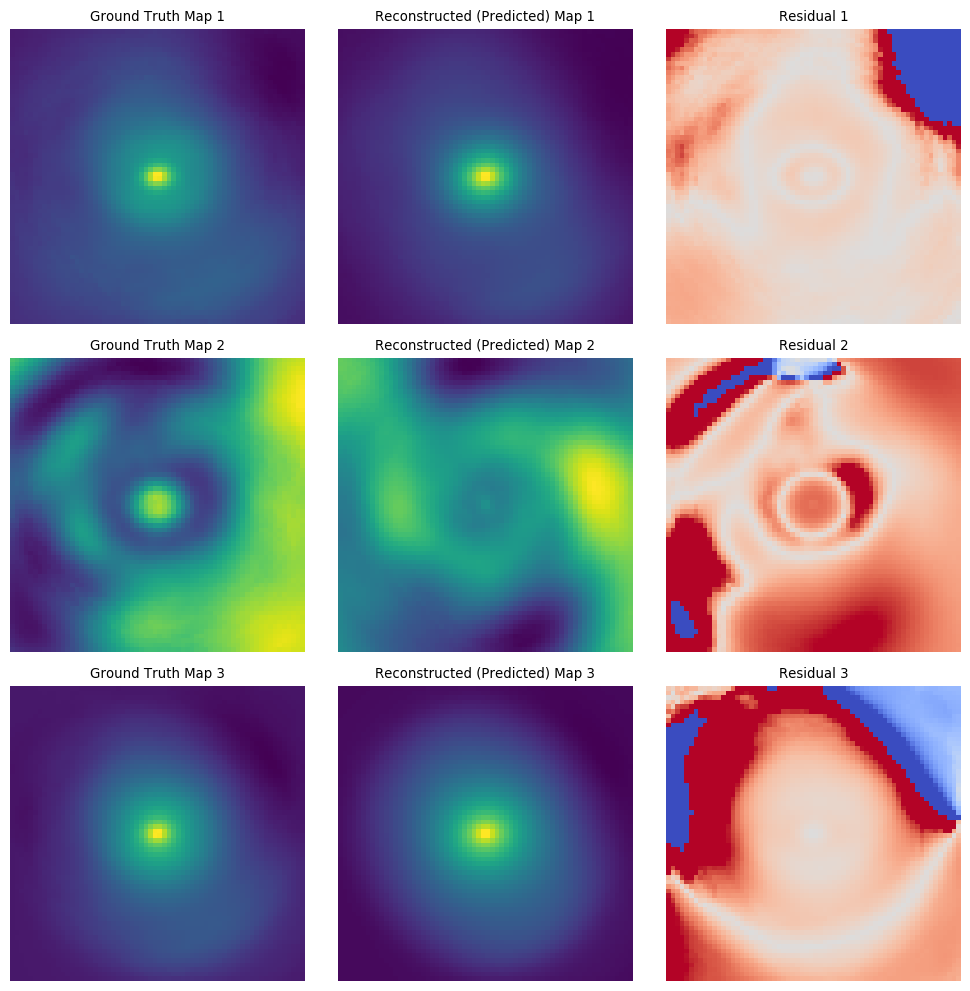

23.291542878947798

In [51]:
rec_errors = [evaluate_prediction(predscores[index], test_targets[index].cpu(), plot=False) for index in range(test_targets.shape[0])]

(array([  3.,  11.,  17.,  53.,  73.,  84., 110., 105., 154., 142., 128.,
        140., 146., 144., 131., 109., 103.,  84.,  99.,  74.,  69.,  52.,
         45.,  52.,  49.,  32.,  40.,  24.,  25.,  26.,  18.,  24.,  15.,
         16.,   6.,  11.,   4.,   3.,  11.,   8.,   5.,   4.,   4.,   4.,
          3.,   7.,   5.,   5.,   2.,   1.,   0.,   1.,   0.,   1.,   1.,
          0.,   2.,   0.,   1.,   1.,   1.,   0.,   1.,   2.,   1.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  5.7944955 ,   6.81220832,   7.82992114,   8.84763396,
          9.86534678,  10.88305961,  11.90077243,  12.91848525,
         13.93619807,  14.95391089,  15.97162371,  16.98933653,
         18.00704935,  19.02476217,  20.04247499,  21.06018781,
         22.07790063,  23.09561345,  24.11332627,  25.13103909

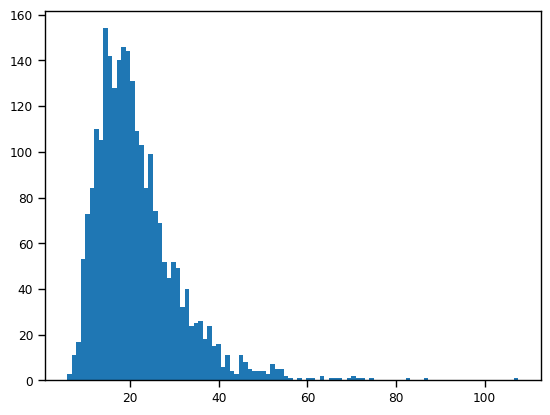

In [52]:
plt.hist(rec_errors, bins = 100)

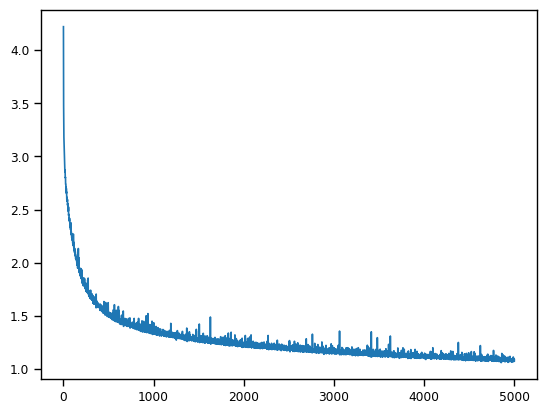

In [53]:
plt.plot(np.arange(len(train_loss)), train_loss)

In [58]:
torch.save(model.state_dict(), 'new_model_snapshot.pth')

  0%|          | 1/7000 [00:00<49:34,  2.35it/s]

Epoch 1/7000, Loss: 1.0637641082144087


  1%|          | 81/7000 [00:31<45:01,  2.56it/s]

Epoch 81/7000, Loss: 1.0772561324629815


  2%|▏         | 161/7000 [01:02<44:29,  2.56it/s]

Epoch 161/7000, Loss: 1.067287538081977


  3%|▎         | 241/7000 [01:33<43:10,  2.61it/s]

Epoch 241/7000, Loss: 1.1045489808556381


  5%|▍         | 321/7000 [02:04<42:36,  2.61it/s]

Epoch 321/7000, Loss: 1.0656841488400841


  6%|▌         | 401/7000 [02:35<42:12,  2.61it/s]

Epoch 401/7000, Loss: 1.0756701846031627


  7%|▋         | 481/7000 [03:06<41:39,  2.61it/s]

Epoch 481/7000, Loss: 1.0577739534104706


  8%|▊         | 561/7000 [03:37<41:09,  2.61it/s]

Epoch 561/7000, Loss: 1.057218599471317


  9%|▉         | 641/7000 [04:08<41:02,  2.58it/s]

Epoch 641/7000, Loss: 1.0562647239417786


 10%|█         | 721/7000 [04:39<40:35,  2.58it/s]

Epoch 721/7000, Loss: 1.05252363271774


 11%|█▏        | 801/7000 [05:11<41:00,  2.52it/s]

Epoch 801/7000, Loss: 1.0836600554976494


 13%|█▎        | 881/7000 [05:43<40:04,  2.54it/s]

Epoch 881/7000, Loss: 1.0494580834534517


 14%|█▎        | 961/7000 [06:14<39:54,  2.52it/s]

Epoch 961/7000, Loss: 1.0525761527620303


 15%|█▍        | 1041/7000 [06:46<38:50,  2.56it/s]

Epoch 1041/7000, Loss: 1.0601764697178153


 16%|█▌        | 1121/7000 [07:17<37:27,  2.62it/s]

Epoch 1121/7000, Loss: 1.039536523211534


 17%|█▋        | 1201/7000 [07:48<37:28,  2.58it/s]

Epoch 1201/7000, Loss: 1.118177529353245


 18%|█▊        | 1281/7000 [08:19<37:02,  2.57it/s]

Epoch 1281/7000, Loss: 1.033608084271668


 19%|█▉        | 1361/7000 [08:50<36:26,  2.58it/s]

Epoch 1361/7000, Loss: 1.038867105723946


 21%|██        | 1441/7000 [09:22<36:37,  2.53it/s]

Epoch 1441/7000, Loss: 1.0327840219637392


 22%|██▏       | 1521/7000 [09:53<36:02,  2.53it/s]

Epoch 1521/7000, Loss: 1.040793232857042


 23%|██▎       | 1601/7000 [10:25<35:24,  2.54it/s]

Epoch 1601/7000, Loss: 1.0902016079349883


 24%|██▍       | 1681/7000 [10:56<33:55,  2.61it/s]

Epoch 1681/7000, Loss: 1.0339832097102122


 25%|██▌       | 1761/7000 [11:27<34:40,  2.52it/s]

Epoch 1761/7000, Loss: 1.0456302363401766


 26%|██▋       | 1841/7000 [11:59<33:28,  2.57it/s]

Epoch 1841/7000, Loss: 1.0273094302529742


 27%|██▋       | 1921/7000 [12:30<33:11,  2.55it/s]

Epoch 1921/7000, Loss: 1.0347711937442707


 29%|██▊       | 2001/7000 [13:01<31:58,  2.61it/s]

Epoch 2001/7000, Loss: 1.028466583437221


 30%|██▉       | 2081/7000 [13:32<31:39,  2.59it/s]

Epoch 2081/7000, Loss: 1.0231130339537458


 31%|███       | 2161/7000 [14:03<31:59,  2.52it/s]

Epoch 2161/7000, Loss: 1.021098090205223


 32%|███▏      | 2241/7000 [14:35<30:35,  2.59it/s]

Epoch 2241/7000, Loss: 1.0102493945200732


 33%|███▎      | 2321/7000 [15:07<31:21,  2.49it/s]

Epoch 2321/7000, Loss: 1.0188599164318886


 34%|███▍      | 2401/7000 [15:39<29:24,  2.61it/s]

Epoch 2401/7000, Loss: 1.0267043804666798


 35%|███▌      | 2481/7000 [16:09<29:03,  2.59it/s]

Epoch 2481/7000, Loss: 1.0191222843091199


 37%|███▋      | 2561/7000 [16:41<29:14,  2.53it/s]

Epoch 2561/7000, Loss: 1.0042783519265


 38%|███▊      | 2641/7000 [17:12<28:44,  2.53it/s]

Epoch 2641/7000, Loss: 1.0193935165739363


 39%|███▉      | 2721/7000 [17:44<27:38,  2.58it/s]

Epoch 2721/7000, Loss: 1.0218120745033215


 40%|████      | 2801/7000 [18:15<29:13,  2.39it/s]

Epoch 2801/7000, Loss: 1.01259867704598


 41%|████      | 2881/7000 [18:46<26:19,  2.61it/s]

Epoch 2881/7000, Loss: 1.0260814090443264


 42%|████▏     | 2961/7000 [19:17<25:58,  2.59it/s]

Epoch 2961/7000, Loss: 1.027430197235885


 43%|████▎     | 3041/7000 [19:48<26:44,  2.47it/s]

Epoch 3041/7000, Loss: 1.0055472045947031


 45%|████▍     | 3121/7000 [20:21<25:55,  2.49it/s]

Epoch 3121/7000, Loss: 1.0121675642432681


 46%|████▌     | 3201/7000 [20:52<24:19,  2.60it/s]

Epoch 3201/7000, Loss: 0.9914919593531615


 47%|████▋     | 3281/7000 [21:23<24:18,  2.55it/s]

Epoch 3281/7000, Loss: 1.0023055019652007


 48%|████▊     | 3361/7000 [21:54<23:43,  2.56it/s]

Epoch 3361/7000, Loss: 0.9960944872752876


 49%|████▉     | 3441/7000 [22:25<23:00,  2.58it/s]

Epoch 3441/7000, Loss: 0.9921710643039388


 50%|█████     | 3521/7000 [22:56<22:20,  2.59it/s]

Epoch 3521/7000, Loss: 1.0289468545063285


 51%|█████▏    | 3601/7000 [23:27<22:01,  2.57it/s]

Epoch 3601/7000, Loss: 1.005050158424742


 53%|█████▎    | 3681/7000 [23:58<21:18,  2.60it/s]

Epoch 3681/7000, Loss: 0.9934440775282064


 54%|█████▎    | 3761/7000 [24:29<20:39,  2.61it/s]

Epoch 3761/7000, Loss: 0.9941867069833598


 55%|█████▍    | 3841/7000 [25:01<21:14,  2.48it/s]

Epoch 3841/7000, Loss: 1.0057029955706018


 56%|█████▌    | 3921/7000 [25:33<20:16,  2.53it/s]

Epoch 3921/7000, Loss: 1.0236047950519878


 57%|█████▋    | 4001/7000 [26:04<19:11,  2.60it/s]

Epoch 4001/7000, Loss: 1.0034030512639671


 58%|█████▊    | 4081/7000 [26:35<18:40,  2.61it/s]

Epoch 4081/7000, Loss: 0.9948655921182815


 59%|█████▉    | 4161/7000 [27:06<18:42,  2.53it/s]

Epoch 4161/7000, Loss: 0.9963101425747962


 61%|██████    | 4241/7000 [27:37<17:54,  2.57it/s]

Epoch 4241/7000, Loss: 1.003812643752736


 62%|██████▏   | 4321/7000 [28:08<17:29,  2.55it/s]

Epoch 4321/7000, Loss: 0.984664511528744


 63%|██████▎   | 4401/7000 [28:39<16:46,  2.58it/s]

Epoch 4401/7000, Loss: 0.9873149030527492


 64%|██████▍   | 4481/7000 [29:11<16:33,  2.54it/s]

Epoch 4481/7000, Loss: 0.9828939874460743


 65%|██████▌   | 4561/7000 [29:43<15:50,  2.57it/s]

Epoch 4561/7000, Loss: 0.9923033467523611


 66%|██████▋   | 4641/7000 [30:14<15:19,  2.56it/s]

Epoch 4641/7000, Loss: 0.9852096852223584


 67%|██████▋   | 4721/7000 [30:45<14:45,  2.57it/s]

Epoch 4721/7000, Loss: 0.9840569162065056


 69%|██████▊   | 4801/7000 [31:17<14:15,  2.57it/s]

Epoch 4801/7000, Loss: 0.9893724064158785


 70%|██████▉   | 4881/7000 [31:48<13:42,  2.58it/s]

Epoch 4881/7000, Loss: 0.9742833341762518


 71%|███████   | 4961/7000 [32:18<12:57,  2.62it/s]

Epoch 4961/7000, Loss: 0.9845973222878328


 72%|███████▏  | 5041/7000 [32:49<12:33,  2.60it/s]

Epoch 5041/7000, Loss: 0.9799184142404301


 73%|███████▎  | 5121/7000 [33:20<12:05,  2.59it/s]

Epoch 5121/7000, Loss: 0.9657139542755807


 74%|███████▍  | 5201/7000 [33:51<11:52,  2.53it/s]

Epoch 5201/7000, Loss: 0.9697827282984546


 75%|███████▌  | 5281/7000 [34:23<11:17,  2.54it/s]

Epoch 5281/7000, Loss: 0.966954460569248


 77%|███████▋  | 5361/7000 [34:55<10:47,  2.53it/s]

Epoch 5361/7000, Loss: 0.9788948381023043


 78%|███████▊  | 5441/7000 [35:27<10:09,  2.56it/s]

Epoch 5441/7000, Loss: 0.966633773533402


 79%|███████▉  | 5521/7000 [35:57<09:28,  2.60it/s]

Epoch 5521/7000, Loss: 0.9960031794134978


 80%|████████  | 5601/7000 [36:28<08:57,  2.60it/s]

Epoch 5601/7000, Loss: 0.9924705768846402


 81%|████████  | 5681/7000 [36:59<08:24,  2.62it/s]

Epoch 5681/7000, Loss: 0.9763789104807908


 82%|████████▏ | 5761/7000 [37:29<07:55,  2.61it/s]

Epoch 5761/7000, Loss: 0.962494197734602


 83%|████████▎ | 5841/7000 [38:00<07:24,  2.61it/s]

Epoch 5841/7000, Loss: 0.9767554641529254


 85%|████████▍ | 5921/7000 [38:31<06:51,  2.62it/s]

Epoch 5921/7000, Loss: 0.9797193092905032


 86%|████████▌ | 6001/7000 [39:01<06:21,  2.62it/s]

Epoch 6001/7000, Loss: 0.9599385261535645


 87%|████████▋ | 6081/7000 [39:32<06:18,  2.43it/s]

Epoch 6081/7000, Loss: 0.9704872996184477


 88%|████████▊ | 6161/7000 [40:03<05:33,  2.52it/s]

Epoch 6161/7000, Loss: 0.9888496163544381


 89%|████████▉ | 6241/7000 [40:35<04:57,  2.55it/s]

Epoch 6241/7000, Loss: 0.9705011556102972


 90%|█████████ | 6321/7000 [41:06<04:21,  2.59it/s]

Epoch 6321/7000, Loss: 0.9754046847106544


 91%|█████████▏| 6401/7000 [41:37<03:50,  2.60it/s]

Epoch 6401/7000, Loss: 0.9644340170416862


 93%|█████████▎| 6481/7000 [42:07<03:20,  2.59it/s]

Epoch 6481/7000, Loss: 0.9834762627531768


 94%|█████████▎| 6561/7000 [42:38<02:48,  2.60it/s]

Epoch 6561/7000, Loss: 0.9745810867115191


 95%|█████████▍| 6641/7000 [43:10<02:22,  2.53it/s]

Epoch 6641/7000, Loss: 0.967978097450961


 96%|█████████▌| 6721/7000 [43:41<01:50,  2.53it/s]

Epoch 6721/7000, Loss: 0.9883822153328331


 97%|█████████▋| 6801/7000 [44:12<01:18,  2.53it/s]

Epoch 6801/7000, Loss: 0.9696028775470272


 98%|█████████▊| 6881/7000 [44:44<00:46,  2.55it/s]

Epoch 6881/7000, Loss: 0.9450082581514007


 99%|█████████▉| 6961/7000 [45:16<00:16,  2.42it/s]

Epoch 6961/7000, Loss: 0.9666382677995475


100%|██████████| 7000/7000 [45:33<00:00,  2.56it/s]


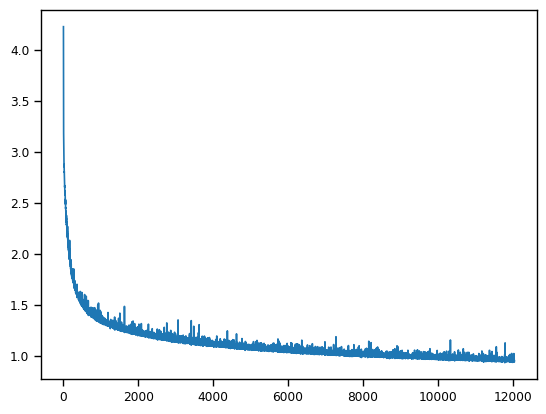

In [56]:
# Continoue training:
model.train()
num_epochs = 7000
for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:  # Iterate over the training set
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch%80 ==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")
        
plt.plot(np.arange(len(train_loss)), train_loss)

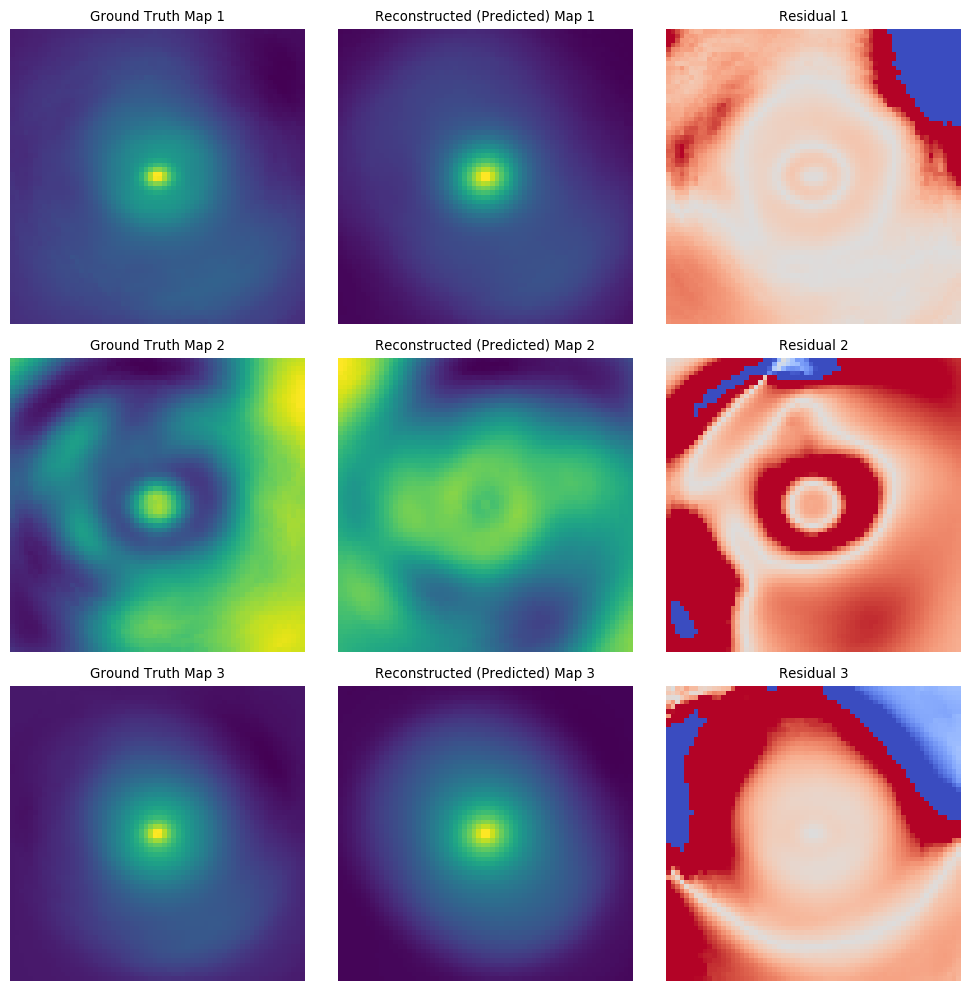

34.502440213013415

In [57]:
# Put the model in evaluation mode
model.eval()

predicted_scores2 = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, targets in test_loader:
        # Move inputs to the GPU device
        inputs = inputs.to(device)

        # Forward pass
        outputs = model(inputs)

        # Move outputs back to the CPU
        outputs = outputs.cpu().numpy()

        predicted_scores2.append(outputs)

# Concatenate predicted PCA components
predscores2 = np.concatenate(predicted_scores2)

index = 22
evaluate_prediction(predscores2[index], test_targets[index].cpu())